## Experiment-specific RT prediction using AutoRT

In this notebook, I will walk you through an example about highly accurate experiment-specific RT prediction using transfer learning strategy in AutoRT with a small training data (~10k peptides) derived from a single MS/MS run from an E. coli label free experiment. This is how users should use AutoRT in most cases.

### Installation

#### Run AutoRT on local computer

Only run the following code when run this notebook on local computer. Make sure all the dependent libraries and packages are installed successfully.

In [ ]:
## install cuda library for tensorflow 2.6
! conda install cudatoolkit=11.2
! conda install -c fastchan cudnn=8.1.0.77

## install AutoRT
! git clone https://github.com/bzhanglab/AutoRT
! ls -l -t
! pip install -r AutoRT/requirements.txt

#### Run AutoRT on Google Colab

Only run the following code when run this notebook on Google Colab. Colab already has all the dependent libraries and packages installed, so we only need to download AutoRT from github.

In [1]:
## install AutoRT
! git clone https://github.com/bzhanglab/AutoRT
! ls -l -t
%cd /content/

Cloning into 'AutoRT'...
remote: Enumerating objects: 555, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 555 (delta 76), reused 42 (delta 18), pack-reused 428
Receiving objects: 100% (555/555), 1.33 GiB | 16.91 MiB/s, done.
Resolving deltas: 100% (264/264), done.
Updating files: 100% (92/92), done.
total 8
drwxr-xr-x 6 root root 4096 Jun 16 23:10 AutoRT
drwxr-xr-x 1 root root 4096 Jun 14 18:27 sample_data
/content


### Example dataset

In this example, we will use the peptides identified from a single MS/MS run to train an experiment-specific RT prediction model. The data is from an E. coli sample and the raw MS/MS data is downloaded from PRIDE with accession number [PXD002140](https://www.ebi.ac.uk/pride/archive/projects/PXD002140). It is from a label free dataset and all the peptides are from a single MS/MS run. For MS/MS searching using MaxQuant (version 2.4.2.0), a fixed modification of Carbamidomethyl (C) and a variable modifications of Oxidation (M) were used. Since all C amino acids were modified, we don't need to encode modified C in AutoRT. For amino acid M, there should have two versions in the dataset, so we need to encode modified M and unmodified M. We use "M" to represent unmodified M and use "1" to represent modified M (Oxidation [M]).This should be consistent with the encoding for modifications in the training data used for base models. There are python and R scripts to process the identification result file (**evidence.txt**) from MaxQuant to generate training and testing data for AutoRT. We will show how to this script below as well.

The example data is in the folder **AutoRT/example/**: data/PXD002140/MURI_100_1a_03312014/evidence.txt.gz

Go to the folder **AutoRT/example/**:

In [2]:
## go to the folder example
%cd AutoRT/example/

/content/AutoRT/example


Check all the data in the foler **AutoRT/example/**:

In [3]:
! ls -l

total 828
drwxr-xr-x 4 root root   4096 Jun 16 23:10 data
-rw-r--r-- 1 root root 292772 Jun 16 23:10 Experiment_specific_RT_prediction_using_AutoRT.ipynb
-rw-r--r-- 1 root root 532275 Jun 16 23:10 Phosphorylation_experiment_specific_RT_prediction_using_AutoRT_Colab.ipynb
-rw-r--r-- 1 root root      1 Jun 16 23:10 README.md
drwxr-xr-x 2 root root   4096 Jun 16 23:10 scripts
-rw-r--r-- 1 root root    373 Jun 16 23:10 train_model_from_scratch.sh
-rw-r--r-- 1 root root    359 Jun 16 23:10 transfer_learning.sh


Load the data in file "evidence.txt":

In [4]:
!gzip -d data/PXD002140/MURI_100_1a_03312014/evidence.txt.gz

In [5]:
import pandas as pd
evidence_df = pd.read_csv("data/PXD002140/MURI_100_1a_03312014/evidence.txt",sep="\t")
print("The number of rows: %d" % (evidence_df.shape[0]))
evidence_df.head()

The number of rows: 24481


,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Oxidation (M),Missed cleavages,Proteins,Leading proteins,...,id,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Taxonomy IDs,Taxonomy names,Mass deficit
0,AAAAEIAVK,9,Unmodified,_AAAAEIAVK_,NaN,NaN,0,0,P0A8D6,P0A8D6,...,0,391,0,0,0,0,NaN,83333.0,Escherichia coli K-12,0.058624
1,AAAAPVTGPLADDPIQETITFDDFAK,26,Unmodified,_AAAAPVTGPLADDPIQETITFDDFAK_,NaN,NaN,0,0,P00959,P00959,...,1,46,1,1,1;2,1,NaN,83333.0,Escherichia coli K-12,0.047652
2,AAAEADDIFGELSSGK,16,Unmodified,_AAAEADDIFGELSSGK_,NaN,NaN,0,0,P19934,P19934,...,2,1109,2,2,3;4,3,NaN,83333.0,Escherichia coli K-12,-0.030098
3,AAAEQSWSLSALTLPHPLVR,20,Unmodified,_AAAEQSWSLSALTLPHPLVR_,NaN,NaN,0,0,P0A8I8,P0A8I8,...,3,405,3,3,5;6,6,NaN,83333.0,Escherichia coli K-12,0.126257
4,AAAESSIQVK,10,Unmodified,_AAAESSIQVK_,NaN,NaN,0,0,P0A8T7,P0A8T7,...,4,431,4,4,7;8;9;10;11;12,8,NaN,83333.0,Escherichia coli K-12,0.033408


#### Generate training data

Use the scripts in folder "AutoRT/example/scripts/" to process the file "evidence.txt" to generate training and testing files.

Running the following command lines will generate two files:
"train_data.tsv" (80% of peptides) and "test_data.tsv" (20% of peptides) in the current folder.

In [6]:
! python /content/AutoRT/example/scripts/process_mq_evidence.py -i data/PXD002140/MURI_100_1a_03312014/evidence.txt -o formated_evidence.txt -m "Phospho (STY)" -f 1
## 0.2: the ratio of split for testing data
! Rscript /content/AutoRT/example/scripts/generate_training_testing_data_for_single_shot_ptm.R formated_evidence.txt 0.2 ./

100% 24481/24481 [00:02<00:00, 8336.18it/s]
Total decoy or contaminant PSMs: 101
Low confident modified peptides: 57
Low score peptides (< 0.000000): 0

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

`summarise()` has grouped output by 'x'. You can override using the `.groups`
argument.
train data: 11989 
test data: 2998 
train data file: .//train_data.tsv 
test data file: .//test_data.tsv 


In [7]:
import pandas as pd
train_data = pd.read_csv("train_data.tsv",sep="\t")
print("The number of unique peptides in the training data: %d" % (train_data.shape[0]))
train_data.head()

The number of unique peptides in the training data: 11989


,x,raw_file,rt_range,rt,n,is_ptm,y
0,FGLTETQAEAILELK,MURI_100_1a_03312014,0.00,210.110,1,N,210.110
1,EYQVQLDIA1QSGKPK,MURI_100_1a_03312014,0.00,59.247,1,N,59.247
2,AIEEGKLESFVTDFYQR,MURI_100_1a_03312014,0.01,198.385,2,N,198.385
3,VSLAADPVEEIK,MURI_100_1a_03312014,0.00,99.123,1,N,99.123
4,SLEEIIR,MURI_100_1a_03312014,0.00,48.016,1,N,48.016


RT distribution in the training data is shown below. The unit of the RT in the data is minute.

<ipython-input-8-34b164c347b3>:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


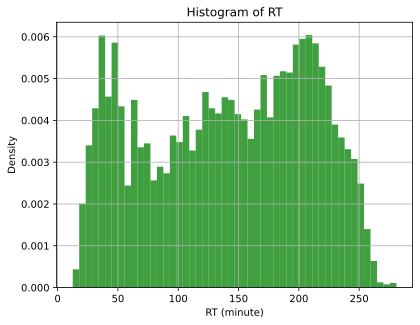

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# the histogram of the data
plt.hist(train_data['y'], 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('RT (minute)')
plt.ylabel('Density')
plt.title('Histogram of RT')
plt.grid(True)
plt.show()


### Training


#### Base model:
The trained base model used here is available at **AutoRT/models/base_models_PXD006109/**. The base model was trained using a large dataset which contains more than 100,000 peptides.The training data for the base model training only contains a fixed modification of Carbamidomethyl (C) and a variable modifications of Oxidation (M).We encoded modified M (Oxidation) using "1".

#### Experiment-specific RT model training:
Below is the command line for training using transfer learning strategy.


In [ ]:
! python ../autort.py train -i train_data.tsv -o tf_model/ -e 40 -b 64 -u m -m ../models/general_base_model/model.json -rlr -n 10

After the training is done, the trained model is in the folder **tf_model/** (-o):

In [ ]:
! ls -l tf_model/

total 197804
-rw-r--r-- 1 root root      120 Jun 16 22:33 aa.tsv
-rw-r--r-- 1 root root 20402248 Jun 16 22:22 model_0.h5
-rw-r--r-- 1 root root 18264800 Jun 16 22:24 model_1.h5
-rw-r--r-- 1 root root 20555848 Jun 16 22:25 model_2.h5
-rw-r--r-- 1 root root 20555864 Jun 16 22:26 model_3.h5
-rw-r--r-- 1 root root 20402264 Jun 16 22:27 model_4.h5
-rw-r--r-- 1 root root 20248648 Jun 16 22:28 model_5.h5
-rw-r--r-- 1 root root 20555864 Jun 16 22:30 model_6.h5
-rw-r--r-- 1 root root 20248648 Jun 16 22:31 model_7.h5
-rw-r--r-- 1 root root 19555176 Jun 16 22:32 model_8.h5
-rw-r--r-- 1 root root 19555160 Jun 16 22:33 model_9.h5
-rw-r--r-- 1 root root      522 Jun 16 22:33 model_all.json
-rw-r--r-- 1 root root      592 Jun 16 22:47 model.json
-rw-r--r-- 1 root root   112035 Jun 16 22:47 models_combination_metrics.tsv
-rw-r--r-- 1 root root   775539 Jun 16 22:21 new_train_data.tsv
drwxr-xr-x 4 root root     4096 Jun 16 22:21 step1
-rw-r--r-- 1 root root    26121 Jun 16 22:33 test_0.csv
-rw-r--r-- 1

### Prediction

The testing data **test_data.tsv** generated above will be used in the prediction.

The column **x** is required which contains the peptides. The column "y" is not required.

In [ ]:
test_data = pd.read_csv("test_data.tsv",sep="\t")
test_data.head()

,x,raw_file,rt_range,rt,n,is_ptm,y
0,VDGVFTADPAK,MURI_100_1a_03312014,0.00,37.824,1,N,37.824
1,DLALEMANR,MURI_100_1a_03312014,0.00,61.828,1,N,61.828
2,VLTPDVVGIDALVHDHQTVLAK,MURI_100_1a_03312014,0.04,183.380,2,N,183.380
3,LRVGAAVGAGAGNEER,MURI_100_1a_03312014,0.00,26.071,1,N,26.071
4,LVPGYEAPVMLAYSAR,MURI_100_1a_03312014,0.08,181.210,2,N,181.210


In [ ]:
! python ../autort.py predict -t test_data.tsv -s tf_model/model.json -o tf_prediction/ -p test

The prediction result is in the file **tf_prediction/test.tsv**. The values in the column **y_pred** are predicted RT. Other files in the same folder are intermediate files which are not useful to users.

In [ ]:
! ls -l tf_prediction/

total 616
-rw-r--r-- 1 root root  68989 Jun 16 22:49 test_0.csv
-rw-r--r-- 1 root root  12120 Jun 16 22:49 test_0.npy
-rw-r--r-- 1 root root  68987 Jun 16 22:49 test_2.csv
-rw-r--r-- 1 root root  12120 Jun 16 22:49 test_2.npy
-rw-r--r-- 1 root root  68996 Jun 16 22:49 test_4.csv
-rw-r--r-- 1 root root  12120 Jun 16 22:49 test_4.npy
-rw-r--r-- 1 root root  68963 Jun 16 22:50 test_5.csv
-rw-r--r-- 1 root root  12120 Jun 16 22:50 test_5.npy
-rw-r--r-- 1 root root  66319 Jun 16 22:50 test_evaluate.csv
-rw-r--r-- 1 root root 230502 Jun 16 22:50 test.tsv


Now we can look at the performance of the RT prediction.

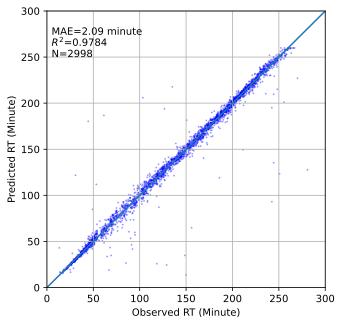

In [ ]:
import sklearn
import scipy
from sklearn.model_selection import train_test_split


pred_data = pd.read_csv("tf_prediction/test.tsv",sep="\t")
pred_data.head()

cor = scipy.stats.pearsonr(pred_data['y'], pred_data['y_pred'])[0]
mae = sklearn.metrics.median_absolute_error(pred_data['y'], pred_data['y_pred'])
r2 = sklearn.metrics.r2_score(pred_data['y'], pred_data['y_pred'])

plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(pred_data['y'], pred_data['y_pred'],s=1, c="blue", alpha=0.3)
plt.text(5, 250, "MAE="+"{:.2f}".format(mae)+" minute\n$R^2$="+"{:.4f}".format(r2)+"\nN="+str(pred_data.shape[0]))
plt.plot( [0,300],[0,300] )
plt.xlabel('Observed RT (Minute)')
plt.ylabel('Predicted RT (Minute)')
plt.xlim(0,300)
plt.ylim(0,300)
plt.grid(True)
plt.show()